<a href="https://colab.research.google.com/github/MiiN1136/Depression-Classification-Model/blob/main/Depression_classification_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt


In [170]:
data = pd.read_csv('student_depression_dataset.csv')

In [171]:
data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,1.000000


##cleaning the **sleep duration** column (*optional*)
This step is just for data cleanup and exploration — it won't affect the rest of the code.

In [172]:
import re  # using regex because it's more flexible

In [173]:
data['Sleep Duration'].unique()

array(["'5-6 hours'", "'Less than 5 hours'", "'7-8 hours'",
       "'More than 8 hours'", 'Others'], dtype=object)

In [174]:
data['Sleep Duration'].value_counts()['Others']

np.int64(18)

In [175]:
sleep_duration = data['Sleep Duration'].unique()
sleep_duration
sleep_durationn = [re.sub(r'[^0-9]', ' ', string).strip() if string != "Others" else '0' for string in sleep_duration]
print(sleep_durationn)

['5 6', '5', '7 8', '8', '0']


In [176]:
test1 = [sleep_durationn[i].split() if not pd.isna(sleep_durationn[i]) else sleep_durationn[i] for i in range(len(sleep_durationn))]

In [177]:
sleep_durationn = [[float(x) for x in t] for t in test1]

In [178]:
sleep_durationn

[[5.0, 6.0], [5.0], [7.0, 8.0], [8.0], [0.0]]

##updating the dataframe with cleaned sleep duration values

###transforming **sleep duration** column into a numerical one

decided to use the average of the given range
* for `less than 5 hours` : the range is [2 : 5]
* for `more than 8 hours` : the range is [8 : 11]

In [179]:
dict_sleep = {"'5-6 hours'": (5+6)/2,
              "'Less than 5 hours'" : (5+2)/2,
              "'7-8 hours'": (7+8)/2,
              "'More than 8 hours'" : (8+11)/2,
              "Others": np.nan
              }

In [180]:
data['Sleep Duration'] = data['Sleep Duration'].map(dict_sleep)

In [181]:
data['Sleep Duration'].value_counts()

,count
Sleep Duration,
3.5,8310
7.5,7346
5.5,6183
9.5,6044


In [182]:
data.head() #checking the updated sleep duration column

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5.5,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5.5,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,3.5,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7.5,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5.5,Moderate,M.Tech,Yes,1.0,1.0,No,0


##One hot encoding

In [183]:
data['Have you ever had suicidal thoughts ?'] = [1 if item == "Yes" else 0 for item in data['Have you ever had suicidal thoughts ?']]

In [184]:
data['Family History of Mental Illness'] = [0 if item == 'No' else 1 for item in data['Family History of Mental Illness']]

In [185]:
data['Gender'] = [0 if item == 'Male' else 1 for item in data['Gender']]

In [186]:
data.head() #checking values after one-hot encoding them

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,0,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5.5,Healthy,B.Pharm,1,3.0,1.0,0,1
1,8,1,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5.5,Moderate,BSc,0,3.0,2.0,1,0
2,26,0,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,3.5,Healthy,BA,0,9.0,1.0,1,0
3,30,1,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7.5,Moderate,BCA,1,4.0,5.0,1,1
4,32,1,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5.5,Moderate,M.Tech,1,1.0,1.0,0,0


##Ordinal encoding

In [187]:
data['Dietary Habits'].unique()

array(['Healthy', 'Moderate', 'Unhealthy', 'Others'], dtype=object)

In [188]:
dietary_habits = data['Dietary Habits'].tolist() #checking data distribution
dietary_habits.count('Healthy'), dietary_habits.count("Moderate"), dietary_habits.count('Unhealthy'), dietary_habits.count('Others')

(7651, 9921, 10317, 12)

In [189]:
data['Dietary Habits'] = [3 if item == 'Healthy' else 2 if item == 'Moderate' else 1 if item == 'Unhealthy' else 0 for item in data['Dietary Habits']]

In [190]:
data.head(5) #checking the 'dietary habits' column after ordinal encoding

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,0,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5.5,3,B.Pharm,1,3.0,1.0,0,1
1,8,1,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5.5,2,BSc,0,3.0,2.0,1,0
2,26,0,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,3.5,3,BA,0,9.0,1.0,1,0
3,30,1,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7.5,2,BCA,1,4.0,5.0,1,1
4,32,1,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5.5,2,M.Tech,1,1.0,1.0,0,0


## cleaning the *Degree* column
Ordinal encoding was applied with respect to this order :
* doctoral & medical > master's degree > bachelor's degree > school-level

In [198]:
data['Degree'].unique()

array(['B.Pharm', 'BSc', 'BA', 'BCA', 'M.Tech', 'PhD', "'Class 12'",
       'B.Ed', 'LLB', 'BE', 'M.Ed', 'MSc', 'BHM', 'M.Pharm', 'MCA', 'MA',
       'B.Com', 'MD', 'MBA', 'MBBS', 'M.Com', 'B.Arch', 'LLM', 'B.Tech',
       'BBA', 'ME', 'MHM', 'Others'], dtype=object)

In [199]:
degree= data['Degree']

In [200]:
data['Degree'] = [4 if item in ['Phd', 'MBSS', 'MD']
                  else 3 if item in ['M.Tech', 'M.Ed', 'MSc',' M.Pharm', 'MCA', 'MA', 'MBA','M.Com', 'ME', 'MHM', 'LLM']
                  else 2 if item in ['B.Pharm', 'BSc', 'BA', 'BCA','B.Ed','LLB','BE','BHM','B.Bom', 'B.Arch', 'B.Tech', 'BBA']
                  else 1
                  for item in degree]

In [201]:
data.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,0,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5.5,3,2,1,3.0,1.0,0,1
1,8,1,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5.5,2,2,0,3.0,2.0,1,0
2,26,0,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,3.5,3,2,0,9.0,1.0,1,0
3,30,1,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7.5,2,2,1,4.0,5.0,1,1
4,32,1,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5.5,2,3,1,1.0,1.0,0,0


## Removing professions other than *Student*

In [191]:
profession_other_than_student = data[data['Profession'] != 'Student']
print(f"Different professions : {profession_other_than_student['Profession'].unique()}\n\nCount per profession : {profession_other_than_student['Profession'].value_counts()} \n\nTotal: {profession_other_than_student['Profession'].count()}")

Different professions : ["'Civil Engineer'" 'Architect' "'UX/UI Designer'" "'Digital Marketer'"
 "'Content Writer'" "'Educational Consultant'" 'Teacher' 'Manager' 'Chef'
 'Doctor' 'Lawyer' 'Entrepreneur' 'Pharmacist']

Count per profession : Profession
Architect                   8
Teacher                     6
'Digital Marketer'          3
Chef                        2
'Content Writer'            2
Pharmacist                  2
Doctor                      2
'UX/UI Designer'            1
'Civil Engineer'            1
Manager                     1
'Educational Consultant'    1
Lawyer                      1
Entrepreneur                1
Name: count, dtype: int64 

Total: 31


In [192]:
total = 27901
(31 / total) *100 #% of professions other than student <<< 5% of total => minority to be removed

0.11110712877674635

In [193]:
not_student_index = data[data['Profession'] != 'Student'].index

In [194]:
for i in not_student_index:
  data = data.drop(i)  #dropping the columns that have a profession other than 'Student'

In [195]:
data.value_counts('Profession') #checking to see whether the corresponding columns were removed correctly or not

,count
Profession,
Student,27870


##dropping the 'Profession' column
Decided to drop the profession column since it's a dummy constant (has all values == 'Student')

In [203]:
data = data.drop('Profession', axis=1)

In [204]:
data.head()

,id,Gender,Age,City,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,0,33.0,Visakhapatnam,5.0,0.0,8.97,2.0,0.0,5.5,3,2,1,3.0,1.0,0,1
1,8,1,24.0,Bangalore,2.0,0.0,5.90,5.0,0.0,5.5,2,2,0,3.0,2.0,1,0
2,26,0,31.0,Srinagar,3.0,0.0,7.03,5.0,0.0,3.5,3,2,0,9.0,1.0,1,0
3,30,1,28.0,Varanasi,3.0,0.0,5.59,2.0,0.0,7.5,2,2,1,4.0,5.0,1,1
4,32,1,25.0,Jaipur,4.0,0.0,8.13,3.0,0.0,5.5,2,3,1,1.0,1.0,0,0


In [205]:
data = data.reset_index(drop=True) # Reset row numbers to start from 0 after dropping rows to keep the index consecutive

## *City* column cleaning

###This column has unstructured data that needs to be either
* removed : useless data such as people names (e.g *Vaanya*) or degrees (e.g *ME*, *M.Com*)
* corrected : incorrectly introduced city names (e.g *Khaziabad* instead of *Ghaziabad*)

In [208]:
data['City'].unique()

array(['Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur',
       'Pune', 'Thane', 'Chennai', 'Nagpur', 'Nashik', 'Vadodara',
       'Kalyan', 'Rajkot', 'Ahmedabad', 'Kolkata', 'Mumbai', 'Lucknow',
       'Indore', 'Surat', 'Ludhiana', 'Bhopal', 'Meerut', 'Agra',
       'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
       'Faridabad', 'Delhi', 'Saanvi', 'M.Tech', 'Bhavna', "'Less Delhi'",
       'City', '3.0', "'Less than 5 Kalyan'", 'Mira', 'Harsha', 'Vaanya',
       'Gaurav', 'Harsh', 'Reyansh', 'Kibara', 'Rashi', 'ME', 'M.Com',
       'Nalyan', 'Mihir', 'Nalini', 'Nandini', 'Khaziabad'], dtype=object)

In [209]:
bad_values = ['Saanvi', 'M.Tech', 'Bhavna', "'Less Delhi'", 'City', '3.0',
              "'Less than 5 Kalyan'", 'Harsha', 'Vaanya', 'Gaurav', 'Harsh',
              'Reyansh', 'Kibara', 'Rashi', 'ME', 'M.Com', 'Mihir', 'Nalini', 'Nandini']

data.loc[data['City'].isin(bad_values), 'City'] = np.nan

In [210]:
data.loc[data['City'] == 'Mira', 'City'] = 'Mira-Bhayandar'

In [211]:
data.loc[data['City'] == 'Nalyan', 'City'] ='Kalyan'

In [212]:
data.loc[data['City'] == 'Khaziabad', 'City'] = 'Ghaziabad'

In [217]:
data['City'].unique()

array(['Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur',
       'Pune', 'Thane', 'Chennai', 'Nagpur', 'Nashik', 'Vadodara',
       'Kalyan', 'Rajkot', 'Ahmedabad', 'Kolkata', 'Mumbai', 'Lucknow',
       'Indore', 'Surat', 'Ludhiana', 'Bhopal', 'Meerut', 'Agra',
       'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
       'Faridabad', 'Delhi', nan, 'Mira-Bhayandar'], dtype=object)

###changing nan cities

In [230]:
data['City'].isna().sum()

np.int64(23)

We're setting the `NaN cities` to a very big negative value, because later on we're changing the column into *latitude* and *longitude* of the introduced city

In [231]:
data.loc[data['City'].isna(), 'City'] = data[data['City'].isna()]['City'].apply(lambda x: -100000.0 if pd.isna(x) else x)

In [232]:
data.loc[data['City'].isna(), 'City']

,City


### cloning the *city* column to add latitude and longitude

In [234]:
data.insert(loc=3, column='City_longi', value=data['City'].copy())

In [235]:
data.insert(loc=4, column='City_lat', value=data['City'].copy())

In [236]:
data = data.drop('City', axis=1)

### adding longi w lati

Tried using `geopy` but got errors due to the massive number of requests, that's why we added the coordinates manually

In [239]:
city_cords_lati = {
    "Visakhapatnam" : 17.6868,
    "Bangalore" : 12.9716,
    "Srinagar" : 34.0837,
    "Varanasi" : 25.3176,
    "Jaipur" : 26.9124,
    "Pune" : 18.5204,
    "Thane" : 19.2183,
    "Chennai" : 13.0827,
    "Nagpur" : 21.1458,
    "Nashik" : 19.9975,
    "Vadodara" : 22.3072,
    "Kaylan": 19.2403,
    "Rajkot" : 22.3039,
    "Ahmedabad" : 23.0225,
    "Kolkata" : 22.5726,
    "Mumbai": 19.0760,
    "Lucknow" : 26.8467,
    "Indore" : 22.7196,
    "Surat": 21.1702,
    "Ludhiana": 30.9000,
    "Bhopal": 23.2599,
    "Meerut": 28.9845,
    "Agra": 27.1767,
    "Ghaziabad": 28.6692,
    "Hyderabad": 17.3850,
    "Vasai-Virar": 19.3919,
    "Kanpur": 26.4499,
    "Patna": 25.5941,
    "Faridabad": 28.4089,
    "Delhi": 28.6139,
    "Mira-Bhayandar": 19.2952,
    "nan": np.nan

}

In [240]:
city_cords_longi = {
    "Visakhapatnam" : 83.2185,
    "Bangalore" : 77.5946,
    "Srinagar" : 74.7973,
    "Varanasi" : 82.9739,
    "Jaipur" : 75.7873,
    "Pune" : 73.8567,
    "Thane" : 72.9781,
    "Chennai" : 80.2707,
    "Nagpur" : 79.0882,
    "Nashik" : 73.7898,
    "Vadodara" : 73.1812,
    "Kaylan": 73.1305,
    "Rajkot" : 70.8022,
    "Ahmedabad" : 72.5714,
    "Kolkata" : 88.3639,
    "Mumbai": 72.8777,
    "Lucknow" : 80.9462,
    "Indore" : 75.8577,
    "Surat": 72.8311,
    "Ludhiana": 75.8500,
    "Bhopal": 77.4126,
    "Meerut": 77.7064,
    "Agra": 78.0081,
    "Ghaziabad": 77.4538,
    "Hyderabad": 78.4867,
    "Vasai-Virar": 72.8397,
    "Kanpur": 80.3319,
    "Patna": 85.1376,
    "Faridabad": 77.3178,
    "Delhi": 77.2090,
    "Mira-Bhayandar": 72.8515,
    "nan": np.nan

}

In [241]:
data['City_lat'] = data['City_lat'].map(city_cords_lati)

In [242]:
data['City_longi'] = data['City_longi'].map(city_cords_longi)

In [244]:
data.head()

,id,Gender,Age,City_longi,City_lat,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,0,33.0,83.2185,17.6868,5.0,0.0,8.97,2.0,0.0,5.5,3,2,1,3.0,1.0,0,1
1,8,1,24.0,77.5946,12.9716,2.0,0.0,5.90,5.0,0.0,5.5,2,2,0,3.0,2.0,1,0
2,26,0,31.0,74.7973,34.0837,3.0,0.0,7.03,5.0,0.0,3.5,3,2,0,9.0,1.0,1,0
3,30,1,28.0,82.9739,25.3176,3.0,0.0,5.59,2.0,0.0,7.5,2,2,1,4.0,5.0,1,1
4,32,1,25.0,75.7873,26.9124,4.0,0.0,8.13,3.0,0.0,5.5,2,3,1,1.0,1.0,0,0


##dropping the *job satisfaction* and *work pressure* columns

We've observed that only a small percentage of the remaining students have work pressure and job satifaction values filled, that is why we decided to drop those 2 columns as well

In [257]:
job_satisfaction = data[data['Job Satisfaction'] != 0].count().sum()
work_pressure = data[data['Work Pressure'] != 0].count().sum()
job_satisfaction, work_pressure

(np.int64(144), np.int64(54))

In [265]:
#calculating the percentage
job_satisfaction_precentage = (job_satisfaction.item() / 27870)*100
work_pressure_percentage = (work_pressure.item() / 27870)*100
print(f"Only {round(job_satisfaction_precentage,2)}% of students have filled the job satisfaction column \nOnly {round(work_pressure_percentage,2)}% of students have filled the work pressure column ")

Only 0.52% of students have filled the job satisfaction column 
Only 0.19% of students have filled the work pressure column 


In [266]:
data = data.drop('Job Satisfaction', axis = 1)

In [267]:
data = data.drop('Work Pressure', axis =1)

In [268]:
data.head()

,id,Gender,Age,City_longi,City_lat,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,0,33.0,83.2185,17.6868,5.0,8.97,2.0,5.5,3,2,1,3.0,1.0,0,1
1,8,1,24.0,77.5946,12.9716,2.0,5.90,5.0,5.5,2,2,0,3.0,2.0,1,0
2,26,0,31.0,74.7973,34.0837,3.0,7.03,5.0,3.5,3,2,0,9.0,1.0,1,0
3,30,1,28.0,82.9739,25.3176,3.0,5.59,2.0,7.5,2,2,1,4.0,5.0,1,1
4,32,1,25.0,75.7873,26.9124,4.0,8.13,3.0,5.5,2,3,1,1.0,1.0,0,0


##'Financial Stress' column cleaning

In [277]:
data['Financial Stress'].value_counts()

,count
Financial Stress,
5.0,6704
4.0,5770
3.0,5219
1.0,5116
2.0,5058
0.0,3


In [271]:
financial_stress = data['Financial Stress']

In [272]:
data.loc[data['Financial Stress'] == '?', 'Financial Stress'] = 0.0

In [273]:
data['Financial Stress'] = [float(financial_stress[i]) if str(financial_stress[i]) else data['Financial Stress'] for i in range(len(financial_stress))]

In [275]:
data['Financial Stress'].dtype

dtype('float64')

In [278]:
data.head()

,id,Gender,Age,City_longi,City_lat,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,0,33.0,83.2185,17.6868,5.0,8.97,2.0,5.5,3,2,1,3.0,1.0,0,1
1,8,1,24.0,77.5946,12.9716,2.0,5.90,5.0,5.5,2,2,0,3.0,2.0,1,0
2,26,0,31.0,74.7973,34.0837,3.0,7.03,5.0,3.5,3,2,0,9.0,1.0,1,0
3,30,1,28.0,82.9739,25.3176,3.0,5.59,2.0,7.5,2,2,1,4.0,5.0,1,1
4,32,1,25.0,75.7873,26.9124,4.0,8.13,3.0,5.5,2,3,1,1.0,1.0,0,0


##Discovering relationships between features and the label 'Depression'

In [280]:
data.corr()

,id,Gender,Age,City_longi,City_lat,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,1.000000,0.004854,0.004032,0.009646,-0.002880,0.005181,-0.012021,0.007861,0.000319,0.010962,-0.004860,0.004579,-0.004189,0.000919,-0.005227,0.001025
Gender,0.004854,1.000000,-0.009034,-0.025372,-0.026541,0.022254,-0.036313,0.015577,0.000866,0.060029,-0.021808,0.001332,-0.013352,0.005344,0.015946,-0.001947
Age,0.004032,-0.009034,1.000000,0.043495,0.038737,-0.075871,0.005167,0.009131,-0.003150,0.057626,0.421441,-0.113654,-0.032775,-0.095277,-0.004973,-0.226738
City_longi,0.009646,-0.025372,0.043495,1.000000,0.023045,0.010788,0.017315,-0.036880,-0.003099,0.003426,0.006905,-0.005728,0.014932,-0.001884,-0.007886,0.004478
City_lat,-0.002880,-0.026541,0.038737,0.023045,1.000000,-0.013116,-0.010054,0.012199,-0.007100,-0.002749,-0.011189,-0.008342,-0.012396,-0.011674,-0.013580,-0.022086
Academic Pressure,0.005181,0.022254,-0.075871,0.010788,-0.013116,1.000000,-0.022325,-0.110903,-0.043384,-0.089305,-0.067610,0.261580,0.096291,0.151941,0.030122,0.474805
CGPA,-0.012021,-0.036313,0.005167,0.017315,-0.010054,-0.022325,1.000000,-0.044227,-0.005176,-0.001908,0.018049,0.008344,0.002613,0.005895,-0.003717,0.022164
Study Satisfaction,0.007861,0.015577,0.009131,-0.036880,0.012199,-0.110903,-0.044227,1.000000,0.012735,0.019825,-0.032252,-0.083652,-0.036510,-0.064932,-0.003789,-0.168132
Sleep Duration,0.000319,0.000866,-0.003150,-0.003099,-0.007100,-0.043384,-0.005176,0.012735,1.000000,-0.001516,-0.002268,-0.054584,-0.028178,-0.004719,-0.012205,-0.087326
Dietary Habits,0.010962,0.060029,0.057626,0.003426,-0.002749,-0.089305,-0.001908,0.019825,-0.001516,1.000000,0.024791,-0.113334,-0.029405,-0.087390,-0.004176,-0.206831


##Transforming clean data into tensors
We're going to use 4 features :
* f0 = have you ever had suicidal thoughts
* f1 = academic pressure
* f2 = financial stress
* f3 = work/study hours

In [295]:
#setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [312]:
x_df = data.iloc[:, [11, 5, 13, 12]]
y_df = data.iloc[:, 15]
x_df.shape, y_df.shape

((27870, 4), (27870,))

In [313]:
x_np = np.array(x_df, dtype=np.float32)
y_np = np.array(y_df, dtype=np.float32)
x_np.shape

(27870, 4)

In [314]:
X = torch.from_numpy(x_np)
y = torch.from_numpy(y_np)

In [315]:
X.shape, y.shape

(torch.Size([27870, 4]), torch.Size([27870]))

# Binary Classification

## data splitting

In [316]:
from sklearn.model_selection import train_test_split

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

In [318]:
X_train.shape, y_train.shape

(torch.Size([22296, 4]), torch.Size([22296]))

## accuracy function

In [319]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum()
  acc = correct.item() / len(y_pred) * 100
  return acc

## building the model

In [320]:
class Depressed_or_notClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features = 4, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features = 32, out_features = 128),
        nn.ReLU(),
        nn.Linear(in_features = 128, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features = 256, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features = 512, out_features =1)
    )

  def forward(self, x):
    return self.layers(x)

###Using Adam as optimizer

In [329]:
torch.manual_seed(42)
model_v1 = Depressed_or_notClassificationModel()

In [330]:
bce = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_v1.parameters(), lr=0.1, weight_decay=1e-4)

In [331]:
sigmoid = nn.Sigmoid()

In [332]:
#uncomment if you need to move the tensors and the model to the GPU
#X_train = X_train.to('cuda')
#X_test = X_test.to('cuda')
#y_train, y_test = y_train.to('cuda'), y_test.to('cuda')
#model_v1 = model_v1.to('cuda')

### Training

In [333]:
epochs = 200

epoch_count = []
train_loss_count = []
test_loss_count = []
accuracy_count = []

for epoch in range(epochs):
  model_v1.train()

  y_pred_logits = model_v1(X_train)
  y_pred = torch.round(sigmoid(y_pred_logits))

  loss = bce(y_pred_logits.squeeze(1), y_train)

  train_accuracy = accuracy_fn(y_train, y_pred.squeeze(1))

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  #testing
  with torch.inference_mode():
    y_pred_test_logits = model_v1(X_test)
    y_pred_test = torch.round(sigmoid(y_pred_test_logits))

    test_loss = bce(y_pred_test_logits.squeeze(1), y_test)

    test_accuracy = accuracy_fn(y_test, y_pred_test.squeeze(1))

  #tracking
  if epoch%10 == 0:
    epoch_count.append(epoch)
    train_loss_count.append(loss)
    test_loss_count.append(test_loss)
    accuracy_count.append([round(train_accuracy,4), round(test_accuracy,4)])



In [334]:
for i in range(len(epoch_count)) :
  print(f"epoch : {epoch_count[i]} | train loss : {train_loss_count[i]} | test loss : {test_loss_count[i]} | train accuracy : {accuracy_count[i][0]} | test accuracy : {accuracy_count[i][1]}")

epoch : 0 | train loss : 0.6817474365234375 | test loss : 592.578369140625 | train accuracy : 58.6697 | test accuracy : 57.8938
epoch : 10 | train loss : 0.613108217716217 | test loss : 0.722866952419281 | train accuracy : 68.7208 | test accuracy : 58.6114
epoch : 20 | train loss : 0.6287747621536255 | test loss : 0.7250523567199707 | train accuracy : 61.9259 | test accuracy : 42.1062
epoch : 30 | train loss : 0.6012076139450073 | test loss : 0.6082980632781982 | train accuracy : 67.2408 | test accuracy : 66.7922
epoch : 40 | train loss : 0.5885810256004333 | test loss : 0.5849600434303284 | train accuracy : 67.3708 | test accuracy : 67.3125
epoch : 50 | train loss : 0.5855788588523865 | test loss : 0.5864318609237671 | train accuracy : 68.0301 | test accuracy : 67.6175
epoch : 60 | train loss : 0.5614786148071289 | test loss : 0.5558484792709351 | train accuracy : 69.5282 | test accuracy : 70.0215
epoch : 70 | train loss : 0.5407220125198364 | test loss : 0.5585581660270691 | train ac

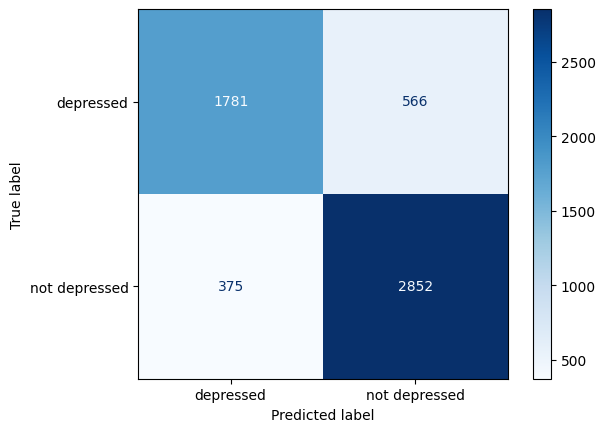

In [335]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

variables = confusion_matrix(y_true= y_test.cpu(), y_pred=y_pred_test.cpu())
ConfusionMatrixDisplay(variables, display_labels = ('depressed','not depressed')).plot(cmap='Blues')
plt.show()

In [337]:
precision = 1781/(1781+375)
print(f"Precision : {round(precision*100, 2)}%")

Precision : 82.61%


In [341]:
recall = 1781 / (1781+566)
print(f"Recall : {round(recall*100, 2)}%")

Recall : 75.88%


In [342]:
f1_score = 2 * ((recall*precision)/(recall+precision))
print(f"F1-score : {round(f1_score*100, 2)}%")

F1-score : 79.1%


##saving the model

In [343]:
from pathlib import Path

path = 'depression_classification_model_v1.pth'

In [345]:
torch.save({
    'model_state_dict' : model_v1.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict()
}, path )